# Practical sampling-based Bayesian inference for multimodal distribution
- [**True posterior distribution by grid approximation**](#True-posterior-distribution-by-grid-approximation)
- [**Gradient Uncertainty algorithm (ours)**](#Gradient-Uncertainty-algorithm-(ours))

In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D # this is needed for working 3d projection

%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [2]:
np.random.seed(1016)

$$ \theta_1 \sim N(0,\sigma_1^2); \quad \theta_2 \sim N(0,\sigma_2^2)  $$
$$ x_i \sim \frac{1}{2}N(\theta_1, \sigma_x^2) + \frac{1}{2}N(\theta_1+\theta_2,\sigma_x^2) $$
where $\sigma_1^2=10$, $\sigma_2^2=1$ and $\sigma_x^2=2$. Data points are generated from mixture of two Gaussian distributions with $\theta_1=0$ and $\theta_2=1$


## True posterior distribution by grid approximation 

### meshgrid & plot function

In [3]:
# make meshgrid
theta0_axis = np.linspace(-3,3,101)
theta1_axis = np.linspace(-3,3,101)
X, Y = np.meshgrid(theta0_axis,theta1_axis)

In [4]:
def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection, aspect='equal'), figsize=(12,4))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.3, cmap=plt.cm.jet)
        ax[1].plot_surface(X, Y, likelihood, alpha=0.3, cmap=plt.cm.jet)
        ax[2].plot_surface(X, Y, posterior, alpha=0.3, cmap=plt.cm.jet)
    else:
        ax[0].contour(X, Y, prior, cmap=plt.cm.jet)
        ax[1].contour(X, Y, likelihood, cmap=plt.cm.jet)
        ax[2].contour(X, Y, posterior, cmap=plt.cm.jet)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.tight_layout()

### generate data

In [5]:
np.random.seed(1016)

In [6]:
sig1,sig2,sigx = np.sqrt(10),1,np.sqrt(2)
mean_stddev = np.array([[0,sigx],
                        [2,sigx]])
n_sample = 100
mixture_idx = np.random.choice(2,size=n_sample,p=[0.5,0.5])
samples = np.array([st.norm(*mean_stddev[idx]).rvs() for idx in mixture_idx])
print(samples.shape)
# plt.hist(samples,bins=20)

(100,)


### Bayesian - Prior, Likelihood, Posterior

In [7]:
prior = lambda thetas: st.norm(0,sig1).pdf(thetas[0]) * st.norm(0,sig2).pdf(thetas[1])

def likelihood(thetas):
    data_likelihood = lambda thetas,data: \
                            (st.norm(thetas[0],sigx).pdf(data) + \
                             st.norm(thetas[0]+thetas[1],sigx).pdf(data)) / 2
    loglikelihood = np.ones(X.shape)
    for sample in samples:
        loglikelihood *= data_likelihood(thetas,sample)
    return loglikelihood

def post(thetas): 
    unnorm_post = lambda thetas: prior(thetas) * likelihood(thetas)
    post = unnorm_post(thetas)
    post = post / (post.sum() * 36. / 10000.)
    return post

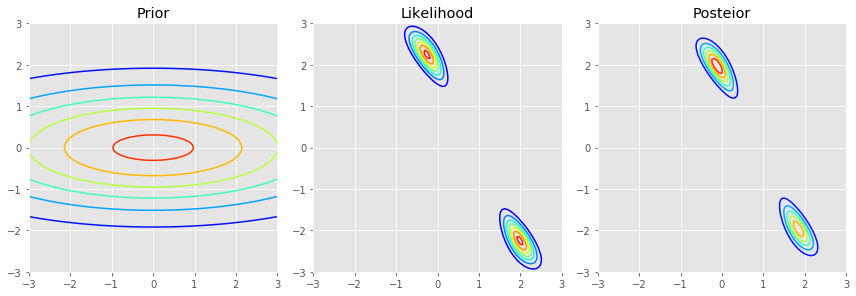

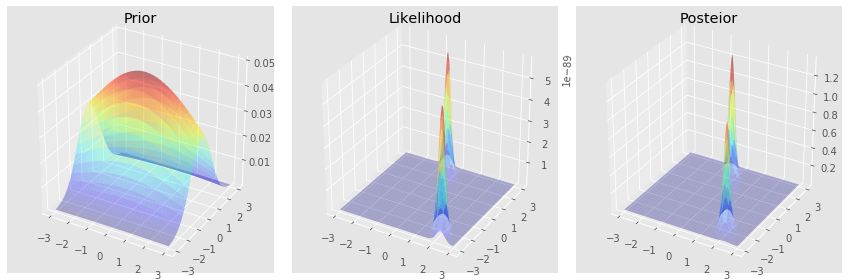

In [8]:
make_plots(X, Y, prior([X,Y]), likelihood([X,Y]), post([X,Y]))
make_plots(X, Y, prior([X,Y]), likelihood([X,Y]), post([X,Y]), projection='3d')

## Gradient Uncertainty algorithm (ours)

$$ gradient \; uncertainty = -\frac{\sum_{i\neq j}\left< \nabla f_i(w), \nabla f_j(w) \right>}{\sum_{i=1}^{n}\left\Vert \nabla f_i(w) \right\Vert_2^2} $$

In [9]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, tqdm_notebook

In [10]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
torch.cuda.is_available()

True

In [11]:
class Gaussian():
    '''input format : torch.Tensor([])'''
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.normal = torch.distributions.Normal(0,1)
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2))

In [12]:
class ScaleMixtureGaussian():
    '''input format : torch.Tensor([])'''
    def __init__(self, mu, mix=[0.5,0.5]):
        self.mix = mix
        self.mu = mu
        self.sigx = torch.sqrt(torch.tensor(2.)).to(device)
    
    def gaussian_log_prob(self, mu, sigma, input):
        return (- torch.log(torch.sqrt(torch.tensor(2 * math.pi)))
                - torch.log(sigma)
                - ((input - mu) ** 2) / (2 * sigma ** 2))
        
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian_log_prob(self.mu[0],self.sigx,input))
        prob2 = torch.exp(self.gaussian_log_prob(self.mu[0]+self.mu[1],self.sigx,input))
        return torch.log(self.mix[0] * prob1 + self.mix[1] * prob2)

In [13]:
class Bayesian(nn.Module):
    def __init__(self):
        super(Bayesian, self).__init__()
        self.thetas = nn.Parameter(torch.tensor([2.,2.]),requires_grad=True)
        
        self.prior1 = Gaussian(torch.tensor(0.).to(device), torch.tensor(np.sqrt(10)).to(device))
        self.prior2 = Gaussian(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.like = ScaleMixtureGaussian(self.thetas)

    def forward(self, input):
        self.log_prior = self.prior1.log_prob(self.thetas[0]) + self.prior2.log_prob(self.thetas[1])
        self.log_like = self.like.log_prob(input).sum()
        self.log_post = self.log_prior + n_sample / len(input) * self.log_like
        return -self.log_post

In [29]:
# setting
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [30]:
class Gradient():
    def __init__(self, params):
        '''
        params should be list format with each index in torch Tensor format
        for example, layers = list(model.layer1.parameters())
        then it would be weight, bias, weight, bias, ... parameters
        '''
        # self.params_grad.shape = batch * (number of parameters)
        n_params = 0
        for param in params:
            n_params += np.prod(param.shape)
        self.params_grad = torch.zeros([batch_size, n_params], dtype=torch.float32).to(device)
    
    def backward(self, params, index):
        # broadcasting
        start = 0
        for param in params:
            n_param = np.prod(param.shape)
            self.params_grad[index, start:start+n_param] = param.grad.view(-1)
            start += n_param
        
    def uncertainty(self):
        denom = self.params_grad.pow(2).sum()
        numer = self.params_grad.sum(dim=0).pow(2).sum() - denom
        uncer = - numer / (denom+1e-100)
            
        return uncer

In [39]:
epochs = 5000
batch_size = 20
lr = 1. / n_sample
iteration = epochs*n_sample//batch_size
print(iteration)

25000


In [40]:
model = Bayesian().to(device)
optimizer = optim.SGD(model.parameters(),lr=lr)

In [41]:
# initialize
params = list(model.parameters())
params_grad = Gradient(params)

saved_thetas = np.zeros([iteration,2])
saved_uncertainty = np.zeros([iteration])
threshold = 149./150.
count = 0

torch_samples = torch.tensor(samples, dtype=torch.float32).to(device)

for epoch in tqdm(range(epochs)):
    # permutation
    torch_samples = torch_samples[torch.randperm(n_sample)]
        
    # run
    for idx in range(n_sample // batch_size):
        batch_samples = torch_samples[idx*batch_size:(idx+1)*batch_size]
        
        # in batch, calculate gradient of each parameters
        for j in range(batch_size):
            one_sample = batch_samples[j:j+1]
            
            optimizer.zero_grad()
            loss = model(one_sample)
            loss.backward()
            
            params_grad.backward(params,j)
        uncertainty = params_grad.uncertainty()
        
        # save values
        saved_uncertainty[n_sample // batch_size * epoch + idx] = uncertainty.cpu().numpy()
        for p in model.parameters():
            saved_thetas[n_sample // batch_size * epoch + idx] = p.data.cpu().numpy()
        
        # model update
        optimizer.zero_grad()
        loss = model(batch_samples)
        loss.backward()
        if uncertainty >= threshold:
            for p in model.parameters():
                p.grad += torch.randn(p.grad.shape).to(device) * torch.pow(torch.tensor(lr),-1)
                count += 1
        optimizer.step()

100%|██████████| 5000/5000 [12:40<00:00,  6.50it/s]


252


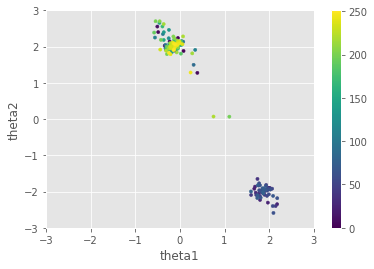

In [42]:
# burn_out = count//10
plot_thetas = saved_thetas[saved_uncertainty>=threshold]
print(len(plot_thetas))
plt.scatter(plot_thetas[:,0], plot_thetas[:,1],s=10,c=np.arange(len(plot_thetas)))
plt.colorbar()
plt.gca().set_xlim([-3,3])
plt.gca().set_ylim([-3,3])
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.show()